In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import datetime, timedelta
import warnings
import seaborn as sns
warnings.simplefilter('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max_columns', 200) # show more columns
RANDOM_SEED = 27 # makes the test repeatable
current_date = pd.to_datetime('2021/03/15') # current date

# 1. Loading the dataset

The datasets contains information about restaurants. This infomation needs to be used to build a regression model capable of predicting the rating of a restaurant. 
First data frame, df_train(main_task.csv) contains information about 40000 restaurants and will be used for training and validating the model.
The df_test('kaggle_task.csv) has information about 10000 restaurants, which rating needs to be predicted.
Following information can be found in the data frames:
1. Restaurant_id - restaurant identification number;
2. City - city in which restaurant is located;
3. Cuisine Style - tags for food that is served in the restaurant;
4. Ranking - rank of a restaurant compared to the other restaurants in the city;
5. Rating -  restaurant rating according to TripAdvisor, dependant variable and the value that needs to be predicted(1 to 5);
6. Price Range - range of prices in a restaurant(category);
7. Number of Reviews — Number of Reviews;
8. Reviews - two reviews displayed on the website and their respective dates;
9. URL_TA — URL on TripAdvisor;
10. ID_TA — Identificator of restaurant in TripAdvisor's DataBase.

In [2]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv('main_task.csv') # dataset for training
df_test = pd.read_csv('kaggle_task.csv') # dataset for validation
sample_submission = pd.read_csv('sample_submission.csv') # submission dataset

In [3]:
# For the correct processing of features, combine train and test sets into a one dataset

df_train['sample'] = 1  # train
df_test['sample'] = 0  # test
# as we have to predict rating, in test set we just fill it with 0
df_test['Rating'] = 0

df = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # combine sets

# 1.1 Basic look at the dataset


In [4]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


In [5]:
# renaming the columns so they are easier to read
df.columns = ['id','city', 'cuisine', 'ranking',
              'prices', 'number_of_reviews', 'reviews', 'url',
              'website_id', 'sample', 'rating']

In [6]:
# at the moment url is not used, so it is dropped at the start
df.drop(['url'], inplace=True, axis=1)

In [7]:
# general look at the number of unique values in df
df.nunique(dropna=False)

id                   13094
city                    31
cuisine              10732
ranking              12975
prices                   4
number_of_reviews     1574
reviews              41858
website_id           49963
sample                   2
rating                  10
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 50000 non-null  object 
 1   city               50000 non-null  object 
 2   cuisine            38410 non-null  object 
 3   ranking            50000 non-null  float64
 4   prices             32639 non-null  object 
 5   number_of_reviews  46800 non-null  float64
 6   reviews            49998 non-null  object 
 7   website_id         50000 non-null  object 
 8   sample             50000 non-null  int64  
 9   rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 3.8+ MB


It appears that the column id has repeatable values, which might be duplicates.
The columns cuisine, prices and number_of_reviews have 9283, 13886 and 2543 NaN values.
Most columns have data dype object, with only ranking, rating and number_of_reviews being float64.

# 1.1 Restaurant ID

In [9]:
df.id = df.id.apply(lambda x: x[3:]) # getting rid of the id_ part

In [10]:
df.loc[df.id == df.id.value_counts().index[0]] # displaying the restaurants that share id

,id,city,cuisine,ranking,prices,number_of_reviews,reviews,website_id,sample,rating
436,436,Lisbon,"['European', 'Portuguese']",2904.0,NaN,2.0,"[[], []]",d5003144,0,0.0
12955,436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",d1592613,1,4.5
14674,436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",d8738362,1,4.0
16118,436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",d9463122,1,4.5
16215,436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",d10438365,1,4.5
17377,436,Luxembourg,['Asian'],437.0,NaN,2.0,"[['ZEN'], ['06/11/2016']]",d743888,1,4.5
18168,436,Oslo,"['European', 'Scandinavian']",437.0,$$$$,51.0,"[['Stunning views over Oslo', 'Brilliant break...",d2036436,1,4.0
18497,436,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",437.0,$$ - $$$,855.0,"[['Nice Napoli style pizza place', 'Great Neap...",d1553645,1,4.0
22554,436,Ljubljana,NaN,437.0,NaN,14.0,"[['Terrible staff and service', 'Disrespectful...",d12607480,1,3.0
23313,436,Krakow,['Vegetarian Friendly'],437.0,$$ - $$$,18.0,"[['Great find, 100% recommend', 'Amazing brunc...",d12404722,1,4.5


It appears that the line are not duplicated, so the restaurants sharing id are just chain restaurants.

In [11]:
# Marking such restaurants should we need it in the future
chain_restaurant = df.id.value_counts()[df.id.value_counts() > 1].index.tolist()
df['chain_restaurant'] = df[df.id.isin(chain_restaurant)].id.apply(lambda x: 1)
df.chain_restaurant = df['chain_restaurant'].fillna(0)

# 1.2 Cities

In [12]:
# check if there are any repetitions/alternative notations for city names
df.city.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: city, dtype: int64

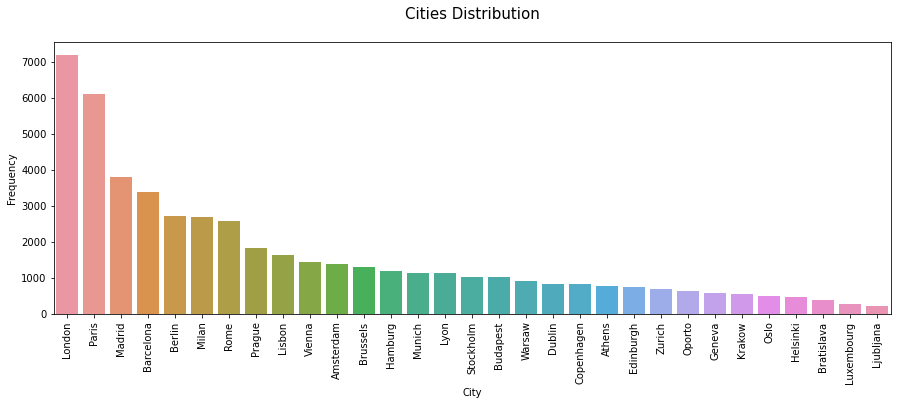

In [13]:
plt.figure(figsize = (15, 5))
sns.countplot(df['city'], order=df['city'].value_counts().index)
plt.title('Cities Distribution\n', fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.xlabel('City')

cities = df.city.unique() # creating list with all the cities

# 1.3 Cuisine

In [14]:
df.cuisine[0], type(df.cuisine[0])

("['Bar', 'Pub']", str)

It appears that data in this column is a string, arrenged to look like a list.

In [15]:
def separation(data):
    '''Function for separation of certain data in the dataset.
       Function takes in a string and returns a
       list of elements of the string'''
    data = data.replace('[','')
    data = data.replace(']','')
    data = data.replace('\'','')
    data = data.lower()
    data = data.split(',')
    data = [element.strip() for element in data]
    return data

In [16]:
# marking the lines that had their values filled in
df['filled_cuisine'] = df[df.cuisine.isna()].cuisine.apply(lambda x: 1)
df['filled_cuisine'] = df['filled_cuisine'].fillna(0)

In [17]:
# Fill in the empty lines and separates the strings, making lists of tags of cuisines
df.cuisine = df.cuisine.fillna('other_cuisine').apply(separation)
cuisine_exploded = df.explode('cuisine')
pd.DataFrame(cuisine_exploded.cuisine.value_counts()) # counts down how often each cousine is seen

,cuisine
vegetarian friendly,14021
european,12561
other_cuisine,11590
mediterranean,7820
italian,7433
...,...
yunnan,2
salvadoran,1
xinjiang,1
burmese,1


In [18]:
# creating a dictionary with most common cuisine in each city
popular_cuisine_dict = {}
for city in cities:
    most_popular_cuisine = cuisine_exploded[
        cuisine_exploded['city'] == city
    ].cuisine.value_counts().index[0]
    popular_cuisine_dict[city] = most_popular_cuisine
popular_cuisine_dict

{'Paris': 'french',
 'Helsinki': 'european',
 'Edinburgh': 'vegetarian friendly',
 'London': 'vegetarian friendly',
 'Bratislava': 'other_cuisine',
 'Lisbon': 'european',
 'Budapest': 'european',
 'Stockholm': 'european',
 'Rome': 'italian',
 'Milan': 'italian',
 'Munich': 'vegetarian friendly',
 'Hamburg': 'other_cuisine',
 'Prague': 'european',
 'Vienna': 'european',
 'Dublin': 'vegetarian friendly',
 'Barcelona': 'spanish',
 'Brussels': 'european',
 'Madrid': 'spanish',
 'Oslo': 'european',
 'Amsterdam': 'european',
 'Berlin': 'other_cuisine',
 'Lyon': 'french',
 'Athens': 'greek',
 'Warsaw': 'european',
 'Oporto': 'portuguese',
 'Krakow': 'european',
 'Copenhagen': 'european',
 'Luxembourg': 'european',
 'Zurich': 'european',
 'Geneva': 'european',
 'Ljubljana': 'european'}

In [19]:
# maps dictionary with common cuisine on the dataframe
df['most_popular_cuisine'] = df.city.map(popular_cuisine_dict)

In [20]:
# looks how many cuisine styles a restaurant offers. 
# Since initially the tags weren't included for some restaurants, their values of number
# of tags are set to 0
df['cuisine_count'] = df.cuisine.apply(lambda x: len(x))
df['cuisine_count'].loc[df.filled_cuisine == 1] = 0

# 1.4 Ranking

Text(0.5, 0, 'Ranking')

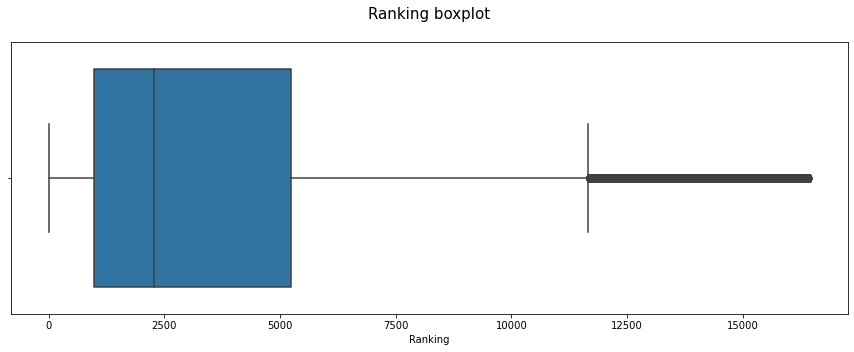

In [21]:
plt.figure(figsize = (15, 5))
sns.boxplot(df.ranking.values)
plt.title('Ranking boxplot\n', fontsize = 15) # boxplot to see the distribution of values of ranking
plt.xlabel('Ranking')

Text(0, 0.5, 'Frequency')

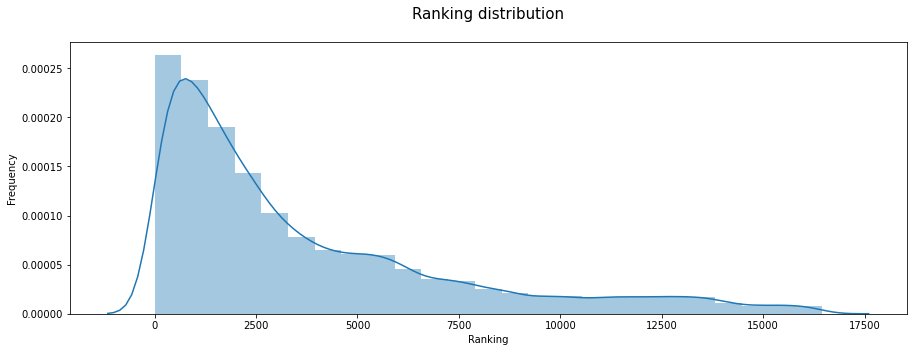

In [22]:
plt.figure(figsize=(15, 5))
sns.distplot(df.ranking.values, bins=25) # How frequent the ranks are
plt.title('Ranking distribution\n', fontsize = 15)
plt.xlabel('Ranking')
plt.ylabel('Frequency')

In [23]:
df['ranking'].describe()

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: ranking, dtype: float64

From the graph, it is seen that distribution 

Text(0, 0.5, 'Quantity (frequency)')

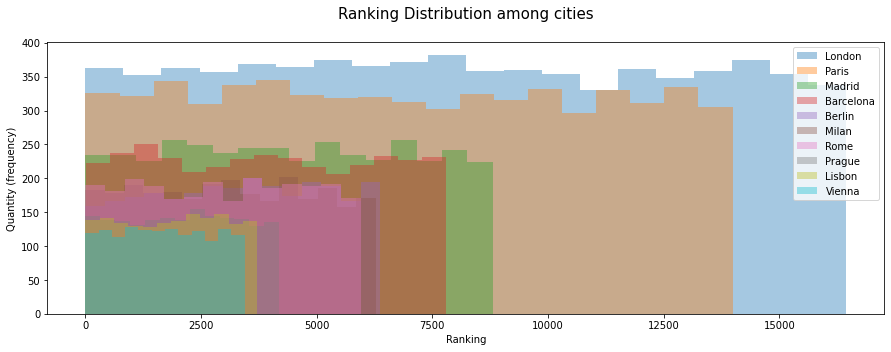

In [24]:
plt.figure(figsize=(15, 5))
for city in (df['city'].value_counts())[0:10].index:
    sns.distplot(df['ranking'][df['city'] == city], kde=False, label=city)

    
plt.legend(prop={'size': 10})
plt.title('Ranking Distribution among cities\n', fontsize=15)
plt.xlabel('Ranking')
plt.ylabel('Quantity (frequency)')

From the graph above it is clear that all the cities use the same distribution, so ranking can be normalised

In [25]:
df['ranking_norm'] = df['ranking']/df.city.map(dict(df['city'].value_counts()))

Text(0, 0.5, 'Quantity (frequency)')

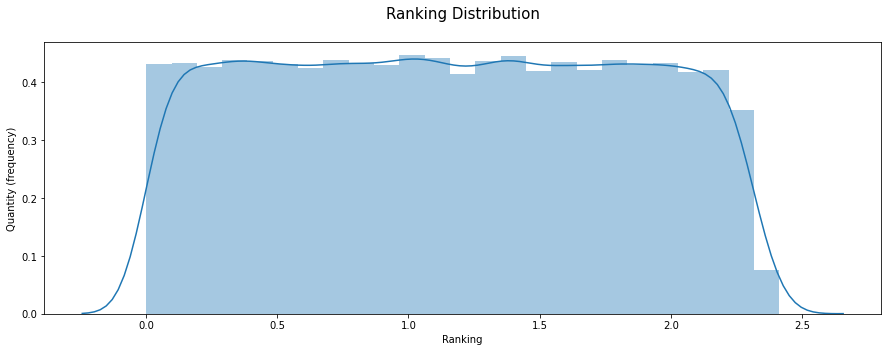

In [26]:
# quick look at the distribution of normalised ranking
plt.figure(figsize=(15, 5))
sns.distplot(df.ranking_norm.values, bins=25)
plt.title('Ranking Distribution\n', fontsize=15)
plt.xlabel('Ranking')
plt.ylabel('Quantity (frequency)')

In [27]:
df['ranking_norm'].describe()

count    50000.000000
mean         1.155723
std          0.667952
min          0.000139
25%          0.577355
50%          1.151105
75%          1.732897
max          2.413100
Name: ranking_norm, dtype: float64

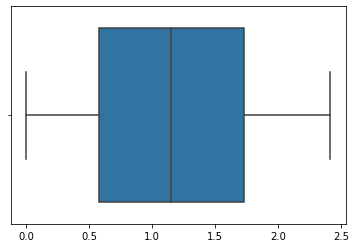

In [28]:
sns.boxplot(df.ranking_norm.values)

# 1.5 Reviews and number of reviews

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

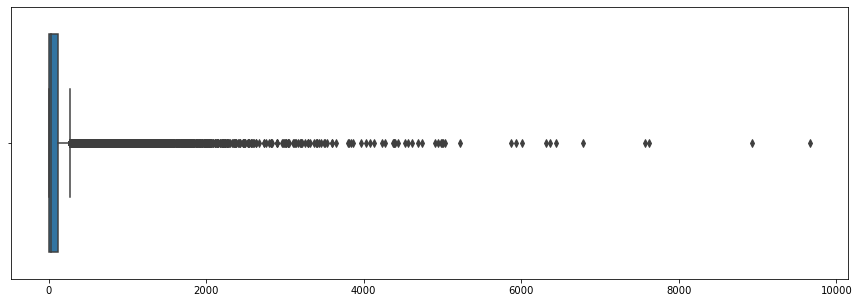

In [29]:
plt.figure(figsize = (15, 5))
sns.boxplot(df.number_of_reviews.values)
df.number_of_reviews.describe()

In [30]:
df.reviews[0], type(df.reviews[0])

('[[], []]', str)

As with cuisine, the reviews column appears to be a string mimicing a list. 
Also, the date of the reviews is attached.

In [31]:
# create a template for search
lrx = re.compile('\[\[.*\]\]')
nan = None

In [32]:
def date_extraction(row):
    '''Function is called for extracting data from column 
    reviews and splitting it out into a separate columns
    INPUT: Whole dataset
    OUTPUT: Dataset with additional columns'''

    cell = row['reviews']
    aux_list = [[], []]  # create an auxilliary list for saving temp.data
    if type(cell) == str and lrx.fullmatch(cell):  # compare with searech template
        aux_list = eval(cell)  # transform into a list
        
    
    row['first_date'] = pd.to_datetime(
    aux_list[1][1] if len(aux_list[1]) > 1 else nan)
    row['last_date'] = pd.to_datetime(aux_list[1][0] if len(
        aux_list[1]) > 0 else nan, format='%m/%d/%Y', errors='coerce')

    row['first_date'] = pd.to_datetime(row['first_date'])
    row['last_date'] = pd.to_datetime(row['last_date'])

    return row


df = df.apply(date_extraction, axis=1)

In [33]:
# find a diffderence between date of the first review and the last one
# add this information into a new column

df['time_difference'] = df['last_date'] - df['first_date']

# call the function and get difference in days
df['time_difference'] = df['time_difference'].apply(
    lambda x: abs(x.days)
)

count    36206.000000
mean       142.548832
std        222.554361
min          0.000000
25%         20.000000
50%         67.000000
75%        173.000000
max       3296.000000
Name: time_difference, dtype: float64

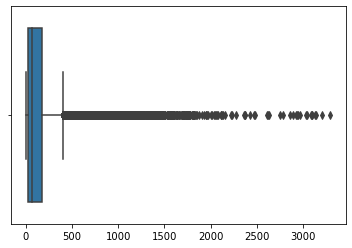

In [34]:
display(df['time_difference'].describe())
sns.boxplot(df['time_difference'].values)

It seems that most reviews have been left over the span of the last 4 months or so.

In [35]:
df['days_since_last_review'] = current_date - df['last_date']
df['days_since_last_review'] = df['days_since_last_review'].apply(
    lambda x: x.days
)

count    41886.000000
mean      1410.746264
std        361.495337
min       1113.000000
25%       1195.000000
50%       1281.000000
75%       1468.000000
max       6172.000000
Name: days_since_last_review, dtype: float64

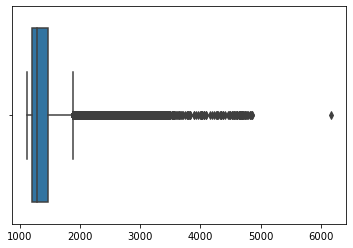

In [36]:
display(df['days_since_last_review'].describe())
sns.boxplot(df['days_since_last_review'].values)

In [37]:
# marking the lines that had their values filled in
df['last_date_filled'] = df[df.last_date.isna()].last_date.apply(lambda x: 1)
df['last_date_filled'] = df['last_date_filled'].fillna(0)
df['first_date_filled'] = df[df.first_date.isna()].first_date.apply(lambda x: 1)
df['first_date_filled'] = df['first_date_filled'].fillna(0)
 
df['last_date'] = df['last_date'].fillna(0)
df['first_date'] = df['first_date'].fillna(0)

In [38]:
df['number_of_reviews'] = df.apply(
    lambda row: 1 if np.isnan(row['number_of_reviews']) and
    (row['last_date'] == 0 or row['first_date'] == 0)
    else row['number_of_reviews'], axis=1
)

In [39]:
df['number_of_reviews'].isna().value_counts()

False    50000
Name: number_of_reviews, dtype: int64

In [40]:
df['days_since_last_review'] = df['days_since_last_review'].fillna(0)
df['time_difference'] = df['time_difference'].fillna(0)

# 1.6 Price Range

In [41]:
df['prices'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: prices, dtype: int64

In [42]:
# price range is hard to read using the original notation, so
# it is converted into categorical data
def price_range_sort(price):
    '''The function takes in a string and replaces it with another string'''
    if price == '$$ - $$$':
        price = 'medium'
    elif price == '$':
        price = 'budget'
    elif price == '$$$$':
        price = 'expensive'
    return price


df['filled_budget'] = df[df.prices.isna()].prices.apply(lambda x: 1) # marking the filled values
df['filled_budget'] = df['filled_budget'].fillna(0)
df.prices = df.prices.fillna('unspecified_budget').apply(price_range_sort)

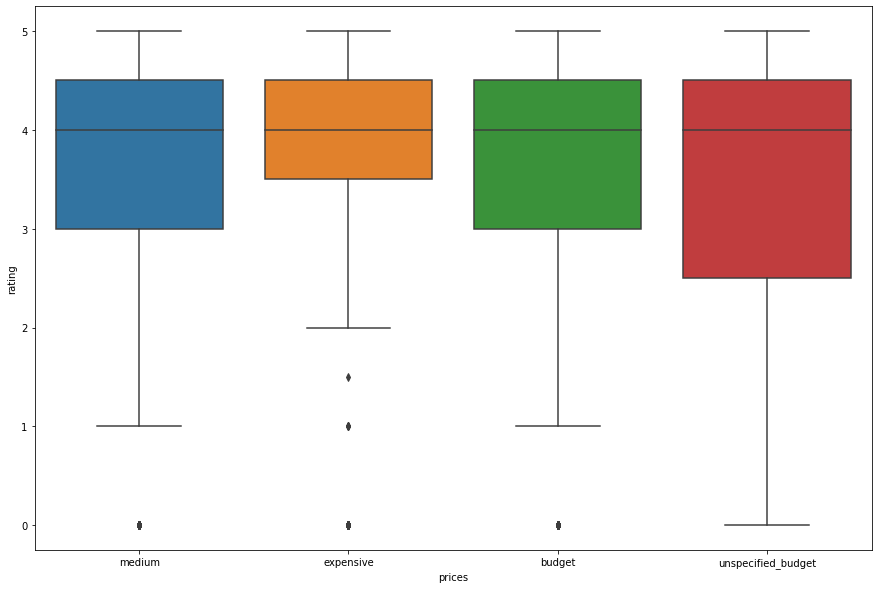

In [43]:
plt.figure(figsize=(15, 10))
sns.boxplot(x = 'prices', y = 'rating',
           data = df)

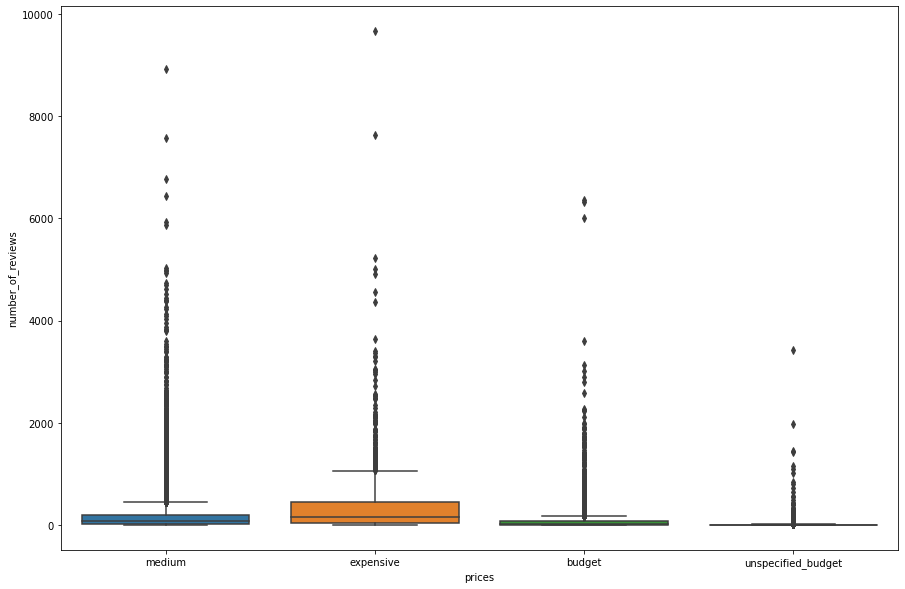

In [44]:
plt.figure(figsize=(15, 10))
sns.boxplot(x = 'prices', y = 'number_of_reviews',
           data = df)

# 1.7 Website ID

In [45]:
# just a few restaurants have a shared website id
shared_web = df.website_id.value_counts()[df.website_id.value_counts() > 1].index.to_list()
df['shared_web'] = df[df.website_id.isin(shared_web)].website_id.apply(lambda x : 1)
df['shared_web'] = df['shared_web'].fillna(0)

# 1.8 Dependant Variable - Rating

In [46]:
df.loc[df['sample'] == 1].rating.describe()

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

There are no empty values for the rating, create a graph to see the distribution:

Text(0, 0.5, 'Quantity (frequency)')

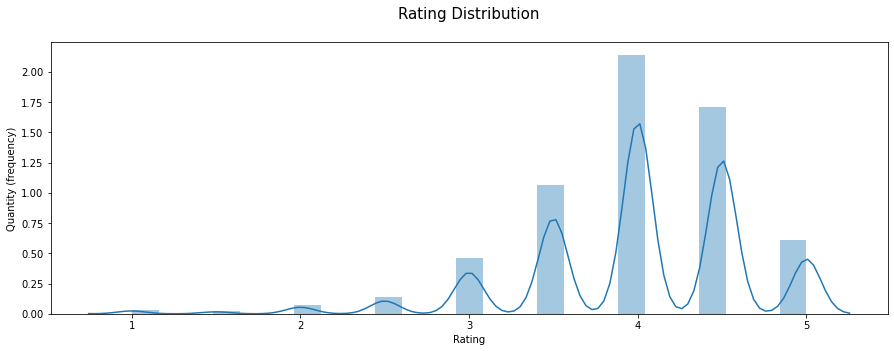

In [47]:
plt.figure(figsize=(15, 5))
sns.distplot(df.loc[df['sample'] == 1].rating.values, bins=25)
plt.title('Rating Distribution\n', fontsize=15)
plt.xlabel('Rating')
plt.ylabel('Quantity (frequency)')

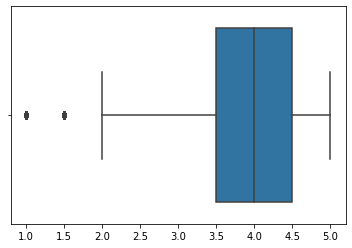

In [48]:
sns.boxplot(df.loc[df['sample'] == 1].rating.values)

The values of rating are mostly in range from 3.5 to 4.5, with anything below 2 being an outlier. It seems that most restaurants have a rating above 3, which should be an average.

It appears that the data in this column is not continuous. Let's check it by using unique():

In [49]:
df.rating.unique()

array([0. , 3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5])

Data is not continuous, and rating takes the values which are multiples of 0.5. This can be used to increase the accuracy of the model.

# 2 New Data
To increase the accuracy of the model, more data added

# 2.1 Population density

In [50]:
# Data adds the popultion(in millions of people) and area(km squared)
data = [[2.2, 105], [1, 188], [8.9, 1706],
         [3.6, 891], [1.5, 310], [0.3, 41.4], 
         [1.4, 181], [0.4, 368], [1.9, 414], 
         [2.9, 1287], [1.7, 101], [3.3, 607], 
         [1.2, 117], [0.2, 32.6], [0.4, 88], 
         [1.8, 517], [1.8, 525], [0.8, 86.4], 
         [0.9, 219], [0.5, 48], [1.9, 755], 
         [0.5,100], [1.3, 496], [0.7, 454], 
         [0.7,213], [0.5, 120], [0.2, 16], 
         [0.3, 163], [0.7, 39], [0.125, 51.5], 
         [0.8, 327]]
city_dict = {}
for i in range(len(cities)):
    city_dict[cities[i]] = data[i] 
city_dict

{'Paris': [2.2, 105],
 'Helsinki': [1, 188],
 'Edinburgh': [8.9, 1706],
 'London': [3.6, 891],
 'Bratislava': [1.5, 310],
 'Lisbon': [0.3, 41.4],
 'Budapest': [1.4, 181],
 'Stockholm': [0.4, 368],
 'Rome': [1.9, 414],
 'Milan': [2.9, 1287],
 'Munich': [1.7, 101],
 'Hamburg': [3.3, 607],
 'Prague': [1.2, 117],
 'Vienna': [0.2, 32.6],
 'Dublin': [0.4, 88],
 'Barcelona': [1.8, 517],
 'Brussels': [1.8, 525],
 'Madrid': [0.8, 86.4],
 'Oslo': [0.9, 219],
 'Amsterdam': [0.5, 48],
 'Berlin': [1.9, 755],
 'Lyon': [0.5, 100],
 'Athens': [1.3, 496],
 'Warsaw': [0.7, 454],
 'Oporto': [0.7, 213],
 'Krakow': [0.5, 120],
 'Copenhagen': [0.2, 16],
 'Luxembourg': [0.3, 163],
 'Zurich': [0.7, 39],
 'Geneva': [0.125, 51.5],
 'Ljubljana': [0.8, 327]}

In [51]:
# adds the data to the data frame
df['population_and_area'] = df.city.map(city_dict)

Creating a new variable of population density. It appears that keping area and population have a positive impact on MAE, so they are kept.

In [52]:
# using the data from the list, calculates the populaion density
df['population'] = df['population_and_area'].apply(lambda x: x[0])
df['area'] = df['population_and_area'].apply(lambda x: x[1])
df['population_density'] = df['population_and_area'].apply(lambda x: x[0]/x[1])
df.drop(['population_and_area'], inplace=True, axis=1)

# 2.2 Capitals
It is possible that restaurants in the capital might have their rating inflated, or they might be better due to
larger number of tourists. to check that, a new column will be created.

In [53]:
capital = [1, 1, 1, 0, 1, 0, 1, 
           1, 1, 1, 1, 1, 0, 0, 
           0, 1, 1, 1, 1, 1, 1, 
           1, 0, 0, 0, 0, 1, 
           1, 1, 1, 1]

capital_dict = {}
for i in range(len(cities)):
    capital_dict[cities[i]] = capital[i] 
capital_dict
df['in_capital'] = df.city.map(capital_dict)

In [54]:
capital = [1, 1, 1, 1, 0, 0,
          0, 1, 1, 1, 0, 1,
          1, 1, 1, 1, 1, 1,
          1, 0, 0, 1, 1, 1,
          1, 0, 0, 1, 1, 1, 0]

capital_dict = {}
for i in range(len(cities)):
    capital_dict[cities[i]] = capital[i] 
capital_dict
df['in_capital'] = df.city.map(capital_dict)

# 3 Preparing the dataset for the model

# 3.1 Correlations
Checking the correlations between the columns, to see if any of them need to be dropped.

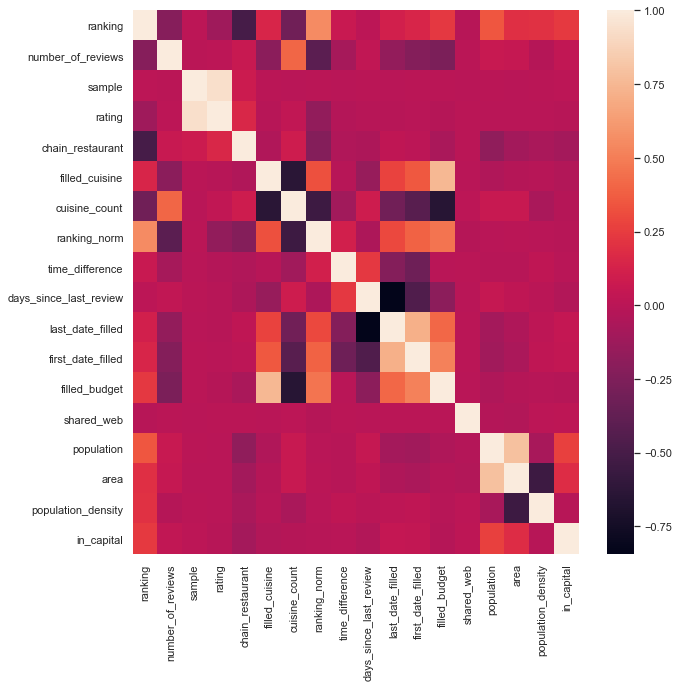

In [55]:
correlations = df.corr()
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.heatmap(correlations)

A few values have very high or very low correlation. For this model, I have decided to treat the absolute value of the correlation of 0.7 or higher as high. Let's display the rows which have correlations that might be outside the boundary:

In [56]:
correlations['ranking'].sort_values()

chain_restaurant         -0.502592
cuisine_count            -0.315655
number_of_reviews        -0.223138
rating                   -0.109897
shared_web               -0.010659
sample                    0.006271
days_since_last_review    0.008939
time_difference           0.069228
last_date_filled          0.107399
first_date_filled         0.149682
filled_cuisine            0.150058
area                      0.193928
population_density        0.203122
filled_budget             0.233946
in_capital                0.243091
population                0.350333
ranking_norm              0.554950
ranking                   1.000000
Name: ranking, dtype: float64

In [57]:
correlations['cuisine_count'].sort_values()

filled_budget            -0.653251
filled_cuisine           -0.637124
ranking_norm             -0.547264
first_date_filled        -0.422012
ranking                  -0.315655
last_date_filled         -0.308960
time_difference          -0.103720
population_density       -0.069361
in_capital               -0.015998
sample                   -0.003096
shared_web                0.012323
rating                    0.032704
area                      0.057519
population                0.058280
days_since_last_review    0.088091
chain_restaurant          0.089495
number_of_reviews         0.402994
cuisine_count             1.000000
Name: cuisine_count, dtype: float64

In [58]:
correlations['time_difference'].sort_values()

first_date_filled        -0.318867
last_date_filled         -0.227373
cuisine_count            -0.103720
number_of_reviews        -0.087440
chain_restaurant         -0.040213
rating                   -0.025971
filled_cuisine           -0.014833
area                     -0.012907
population               -0.009598
sample                   -0.005773
filled_budget            -0.004209
in_capital               -0.004098
shared_web                0.004160
population_density        0.022223
ranking                   0.069228
ranking_norm              0.109222
days_since_last_review    0.236064
time_difference           1.000000
Name: time_difference, dtype: float64

In [59]:
correlations['population_density'].sort_values()

area                     -0.546522
population               -0.074173
chain_restaurant         -0.072634
cuisine_count            -0.069361
number_of_reviews        -0.018119
filled_budget            -0.013370
in_capital               -0.010398
filled_cuisine           -0.010179
rating                   -0.007755
ranking_norm             -0.006538
sample                   -0.000364
days_since_last_review    0.000710
shared_web                0.008588
last_date_filled          0.017432
time_difference           0.022223
first_date_filled         0.024843
ranking                   0.203122
population_density        1.000000
Name: population_density, dtype: float64

In [60]:
correlations['rating'].sort_values()

ranking_norm             -0.168728
ranking                  -0.109897
time_difference          -0.025971
filled_budget            -0.020519
in_capital               -0.014276
filled_cuisine           -0.010781
last_date_filled         -0.010309
days_since_last_review   -0.008713
population_density       -0.007755
area                     -0.007404
first_date_filled        -0.005352
population               -0.004565
shared_web                0.000034
number_of_reviews         0.011006
cuisine_count             0.032704
chain_restaurant          0.150831
sample                    0.936543
rating                    1.000000
Name: rating, dtype: float64

It appears that certain parameters have a fairly high correlation between them, but none of them were over the treshhold of 0.7.

# 3.2 Creating dummies
Creating dummy variables so the model can use them for prediction:

In [61]:
df.head(2)

,id,city,cuisine,ranking,prices,number_of_reviews,reviews,website_id,sample,rating,chain_restaurant,filled_cuisine,most_popular_cuisine,cuisine_count,ranking_norm,first_date,last_date,time_difference,days_since_last_review,last_date_filled,first_date_filled,filled_budget,shared_web,population,area,population_density,in_capital
0,0,Paris,"[bar, pub]",12963.0,medium,4.0,"[[], []]",d10746918,0,0.0,1.0,0.0,french,2,2.122299,0,0,0.0,0.0,1.0,1.0,0.0,0.0,2.2,105.0,0.020952,1
1,1,Helsinki,"[european, scandinavian, gluten free options, ...",106.0,medium,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",d6674944,0,0.0,1.0,0.0,european,5,0.223158,2017-10-29 00:00:00,2017-12-05 00:00:00,37.0,1196.0,0.0,0.0,0.0,0.0,1.0,188.0,0.005319,1


In [62]:
city_dummies = pd.get_dummies(df.city)
cuisine_dummies = pd.get_dummies(df.cuisine.apply(pd.Series).stack()).sum(level = 0)
prices_dummies = pd.get_dummies(df.prices)

In [63]:
np.shape(city_dummies)
np.shape(cuisine_dummies)
np.shape(prices_dummies)

(50000, 4)

# 3.3 Removing columns from the model dataframe
Certain columns can not be used by the model, so they are added to the list 'to_drop' and then dropped.
Colums that had negative impact on MAE are added to 'negative_impact' list and then dropped.

In [64]:
df_model = df.loc[df['sample'] == 1]

In [65]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 10000 to 49999
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      40000 non-null  object 
 1   city                    40000 non-null  object 
 2   cuisine                 40000 non-null  object 
 3   ranking                 40000 non-null  float64
 4   prices                  40000 non-null  object 
 5   number_of_reviews       40000 non-null  float64
 6   reviews                 40000 non-null  object 
 7   website_id              40000 non-null  object 
 8   sample                  40000 non-null  int64  
 9   rating                  40000 non-null  float64
 10  chain_restaurant        40000 non-null  float64
 11  filled_cuisine          40000 non-null  float64
 12  most_popular_cuisine    40000 non-null  object 
 13  cuisine_count           40000 non-null  int64  
 14  ranking_norm            40000 non-

Dropping columns that the model can not use for prediction. Columns 'filled_cuisine', 'filled_budget', 'chain_restaurant', 'shared_web', 'last_date_filled', 'first_date_filled' appear to have a negative impact on MAE, therefore are dropped.

In [66]:
to_drop = ['id', 'city', 'cuisine', 'prices',
           'reviews', 'website_id', 'most_popular_cuisine',
          'first_date', 'last_date', 'sample']
negative_impact = [ 'filled_cuisine', 'filled_budget',
                   'chain_restaurant', 'shared_web',
                   'last_date_filled', 'first_date_filled']

The dropping lines are separated so the model can be tested with the columns that have negative impact on the model.

In [67]:
df_model = df_model.drop(to_drop, axis=1)
df_model = df_model.drop(negative_impact, axis=1)

In [68]:
np.shape(df_model)

(40000, 11)

In [69]:
# merging dummies with the dataframe made for the model training
df_model = df_model.merge(city_dummies,
                          left_index=True, right_index=True)
df_model = df_model.merge(cuisine_dummies,
                          left_index=True, right_index=True)
df_model = df_model.merge(prices_dummies,
                          left_index=True, right_index=True)

In [70]:
np.shape(df_model)

(40000, 172)

In [71]:
df_model.head()

,ranking,number_of_reviews,rating,cuisine_count,ranking_norm,time_difference,days_since_last_review,population,area,population_density,in_capital,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,afghani,african,albanian,american,arabic,argentinean,armenian,asian,australian,austrian,azerbaijani,balti,bangladeshi,bar,barbecue,belgian,brazilian,brew pub,british,burmese,cafe,cajun & creole,cambodian,canadian,caribbean,caucasian,central american,central asian,central european,chilean,chinese,colombian,contemporary,croatian,cuban,czech,danish,delicatessen,diner,dutch,eastern european,ecuadorean,egyptian,ethiopian,european,fast food,filipino,french,fujian,fusion,gastropub,georgian,german,gluten free options,greek,grill,halal,hawaiian,healthy,hungarian,indian,indonesian,international,irish,israeli,italian,jamaican,japanese,korean,kosher,latin,latvian,lebanese,malaysian,mediterranean,mexican,middle eastern,minority chinese,mongolian,moroccan,native american,nepali,new zealand,norwegian,other_cuisine,pakistani,persian,peruvian,pizza,polish,polynesian,portuguese,pub,romanian,russian,salvadoran,scandinavian,scottish,seafood,singaporean,slovenian,soups,south american,southwestern,spanish,sri lankan,steakhouse,street food,sushi,swedish,swiss,taiwanese,thai,tibetan,tunisian,turkish,ukrainian,uzbek,vegan options,vegetarian friendly,venezuelan,vietnamese,welsh,wine bar,xinjiang,yunnan,budget,expensive,medium,unspecified_budget
10000,5570.0,194.0,3.5,3,0.911919,41.0,1170.0,2.2,105.0,0.020952,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10001,1537.0,10.0,4.0,0,1.487899,382.0,1348.0,0.4,368.0,0.001087,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10002,353.0,688.0,4.5,7,0.049075,2.0,1162.0,3.6,891.0,0.004040,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0
10003,3458.0,3.0,5.0,0,1.278373,0.0,0.0,1.9,755.0,0.002517,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
10004,621.0,84.0,4.0,3,0.542358,272.0,1213.0,1.7,101.0,0.016832,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


# 4. Model
X - independent variable, data set with the information about the restaurants;
y - dependant variable, rating of a restaurant, which the model is trying to predict

In [72]:
X = df_model.drop(['rating'], axis = 1)
y = df_model['rating']

In [73]:
# X and y train are used for training the model
# X and y test are used for validation of the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = RANDOM_SEED)

In [74]:
# Importing:
from sklearn.ensemble import RandomForestRegressor # for creating and training a model
from sklearn import metrics # for assessing model accuracy

In [75]:
# Creating the model
regr = RandomForestRegressor(n_estimators=100)

# Training the model
regr.fit(X_train, y_train)

# Validating the model by predicting rating for X_test
# Saving the values into y_pred
y_pred = regr.predict(X_test)

In 1.8 it is shown that rating is not continues, so to increase the accuracy the values are rounded to the multipes of 0.5. It appears it has a very positive impact on MAE, reducing it by 0.02 or so:

In [76]:
def round_rating_pred(rating_pred):
    '''INPUT: a value of the rating
    OUTPUT: a value \'rounded\' to a multiple of 0.5'''
    if rating_pred <= 0.5:
        return 0.0
    if rating_pred <= 1.5:
        return 1.0
    if rating_pred <= 1.75:
        return 1.5
    if rating_pred <= 2.25:
        return 2.0
    if rating_pred <= 2.75:
        return 2.5
    if rating_pred <= 3.25:
        return 3.0
    if rating_pred <= 3.75:
        return 3.5
    if rating_pred <= 4.25:
        return 4.0
    if rating_pred <= 4.75:
        return 4.5
    return 5.0

for i in range(len(y_pred)):
    y_pred[i] = round_rating_pred(y_pred[i])

In [77]:
# Compares the y_pred and y_test, showing the mean absolute error
# between the two values
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1737


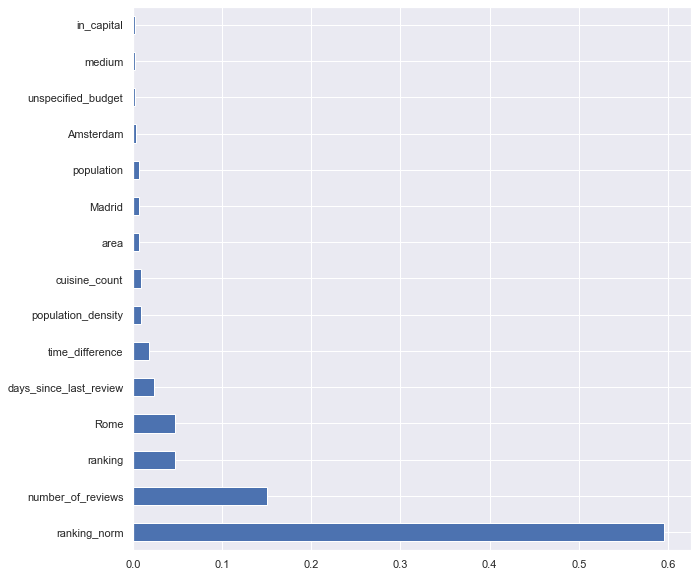

In [78]:
# Shows which values have the most impact on the prediction
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# 5. Applying the model and submitting the result
Repeating the process done with the training DF and submitting the result#


In [79]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [80]:
final_df = df.loc[df['sample'] == 0]

In [81]:
final_df = final_df.drop('rating', axis = 1)

In [82]:
final_df = final_df.drop(to_drop, axis=1)
final_df = final_df.drop(negative_impact, axis=1)

In [83]:
np.shape(final_df)

(10000, 10)

In [84]:
final_df = final_df.merge(city_dummies, left_index=True, right_index=True)
final_df = final_df.merge(cuisine_dummies, left_index=True, right_index=True)
final_df = final_df.merge(prices_dummies, left_index=True, right_index=True)

In [85]:
np.shape(final_df)

(10000, 171)

In [86]:
predict_submission = regr.predict(final_df)
for i in range(len(predict_submission)):
    predict_submission[i] = round_rating_pred(predict_submission[i])

In [87]:
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4.5, 4.5])

In [88]:
sample_submission['Rating'] = predict_submission

In [89]:
sample_submission

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
...,...,...
9995,id_9995,4.5
9996,id_9996,4.0
9997,id_9997,3.0
9998,id_9998,4.5


# Analysis of my work
## General look
There were plenty of expected and unexpected results. Feature Engineering provided to be the hardest aspect of this task, as well as I discovered some interesting methods to working with given data. Certain things came up from random mistakes(e.g. keeping both the ranking and normalised ranking columns).
## Potential Improvements
Over the course of the task, I didn't manage to use the entirety of the data given - I wish I could use the most popular cuisine per city, or make a simple analysis of the reviews, yet I did not have enough time. I would also like to improve visual representation of the code, making it more structural, and potentially adding classes, but I was not confident enough in my own ability to work with them, so I decided to stick to the conventional code and convetional functions. The code could also be improved by adding a few extra functions, and possibly the acuracy of the model can be improved by dropping some columns that have little to no impact on the MAE. Decreacing the boundary for correlations might also increase the accuracy of the model.
## Things I Liked About My Model
My initial goal was to break the barrier of 0.2, which I managed to do, ending up with MAE of 0.1753. One of the most unpected things was the effect rounding had on MAE, changing it by 0.02, which was one of the biggest jumps in this value. I also did not expect the status of a capital to have any effect on MAE, but apparently it was more important than I initially expected. During one of the tests, I forgot to drop the ranking column, and I figured out that ranking and normalised ranking both helped the model to increase the accuracy.

In [90]:
sample_submission.to_csv('submission.csv', index=False)